## 本文档用于图像与城市语义特征的聚类分析，包含以下关键步骤：

### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量
- 图像数据来源于 patch 周边的城市形态渲染图
- 城市语义向量包括地理加权回归得到的权重指标，用于增强聚类的空间语义表达

### 2. 特征处理：使用卷积神经网络（CNN）提取图像特征向量
- 可使用预训练模型（如 ResNet、VGG）提取高维图像嵌入
- 对语义向量进行标准化处理后拼接进图像特征

### 3. 聚类前评估：使用平均轮廓系数法（Silhouette Score）评估最优聚类数 K
- 遍历不同 K 值，绘制轮廓系数曲线
- 选择得分最高或变化平稳的 K 作为最终聚类数

### 4. 降维与可视化：使用主成分分析（PCA）对高维特征进行 2D 或 3D 映射
- 降维后绘制散点图，查看不同聚类的空间分布
- 分析各主成分的含义（如城市形态 vs. 功能语义）

### 5. 聚类分析：应用 KMeans 等聚类算法对图像+语义向量进行聚类
- 保存聚类标签，评估每类的代表性与空间分布

### 6. 聚类结果输出与解释
- 将聚类标签映射回原始 patch 图像与 GeoDataFrame 中
- 可视化聚类分布、类别图像示例、以及与城市变量的关系

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon,Point
import os


#### 1. 数据准备：提取图像的 RGB 特征，并融合 GWR 加权得到的城市语义向量

In [5]:
def square_buffer(center_point, half_size=300):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

building = gpd.read_file("processing_data/img/building_black").to_crs(epsg=32632)
farming = gpd.read_file("processing_data/img/farming_green").to_crs(epsg=32632)
processing = gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)
road = gpd.read_file("processing_data/img/road_grey").to_crs(epsg=32632)
water = gpd.read_file("processing_data/img/water_blue").to_crs(epsg=32632)

processing_center = processing.unary_union.centroid

# output_dir = "playground/Render_Images"
output_dir = "playground/Render_Images_3"
os.makedirs(output_dir, exist_ok=True)


# 4. 渲染函数：以一个点为中心，裁剪5km范围并渲染图像
def render_one_image(center_point, index):
    buffer = square_buffer(center_point, half_size=150)  # 250m 半径 = 500m 宽正方形

    def clip_layer(gdf): return gdf[gdf.geometry.intersects(buffer)]

    bld_clip = clip_layer(building)
    farm_clip = clip_layer(farming)
    proc_clip = clip_layer(processing)
    road_clip = clip_layer(road)
    water_clip = clip_layer(water)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor("white")

    # 顺序渲染
    water_clip.plot(ax=ax, color='blue', edgecolor='none')
    farm_clip.plot(ax=ax, color='green', edgecolor='none')
    road_clip.plot(ax=ax, color='grey', linewidth=5)
    bld_clip.plot(ax=ax, color='black', edgecolor='none')
    proc_clip.plot(ax=ax, color='red')

    ax.set_xlim(buffer.bounds[0], buffer.bounds[2])
    ax.set_ylim(buffer.bounds[1], buffer.bounds[3])
    ax.axis("off")

    plt.tight_layout()
    save_path = os.path.join(output_dir, f"render_{index:03d}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()

    # 5. 遍历 processing 图层的每个 geometry（通常是 Polygon 或 Point）
for idx, row in processing.iterrows():
    center = row.geometry.centroid
    render_one_image(center, idx)

print(f"✅ 共生成 {len(processing)} 张图，保存在 {output_dir}/ 中")

C:\Users\Elena\AppData\Local\Temp\ipykernel_2816\4119511185.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  processing_center = processing.unary_union.centroid
C:\Users\Elena\AppData\Local\Temp\ipykernel_2816\4119511185.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_2816\4119511185.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_2816\4119511185.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_clip.plot(ax=ax, color='blue', edgecolor='none')
C:\Users\Elena\AppData\Local\Temp\ipykernel_2816\4119511185.py:36: UserWarning: The GeoDataFrame you are attempting to pl

✅ 共生成 60 张图，保存在 playground/Render_Images_3/ 中


In [13]:
from PIL import Image
import numpy as np
import os

image_folder = "playground\Render_Images_3"
img_list = []

for i in range(60):
    img = Image.open(os.path.join(image_folder, f"render_{i:03d}.png")).resize((224, 224)).convert("RGB")
    img_array = np.array(img) / 255.0
    img_list.append(img_array)

img_array_all = np.stack(img_list)  # shape: (103, 224, 224, 3)

Index(['farming_ar', 'aquacultur', 'pasture_ar', 'energy_are', 'transporta',
       'retail_cou', 'public_ser', 'consumptio', 'waste_trea', 'road_lengt',
       'intersecti', 'built_area', 'entropy_pr', 'entropy_la', 'beta_Inter',
       'beta_farmi', 'beta_aquac', 'beta_pastu', 'beta_energ', 'beta_trans',
       'beta_retai', 'beta_publi', 'beta_road_', 'beta_built', 'beta_entro',
       'beta_ent_1', 'R2_local', 'geometry'],
      dtype='object')


### 获取城市语义

In [23]:
patches_with_gwr = gpd.read_file("processing_data/patches_with_gwr")
# print(patches_with_gwr)
from sklearn.preprocessing import StandardScaler
# 原始变量字段
# raw_cols = [
#     'farming_ar', 'aquacultur', 'pasture_ar', 'energy_are', 'transporta',
#     'retail_cou', 'public_ser', 'road_lengt','built_area','entropy_pr', 'entropy_la'
# ]

# 对应的 GWR β 字段（名称与你的一致）
beta_cols = [
    'beta_farmi', 'beta_aquac', 'beta_pastu', 'beta_energ', 'beta_trans',
    'beta_retai', 'beta_publi', 'beta_road_', 'beta_built', 'beta_entro', 'beta_ent_1'
]
# 逐列相乘得到“机制语义向量”
mechanism_features = []


for beta in beta_cols:
    # raw_val = patches_with_gwr[raw].astype(float)
    beta_val = patches_with_gwr[beta].astype(float)
    beta_scaled = StandardScaler().fit_transform(beta_val.values.reshape(-1, 1)).flatten()
    contribution =  beta_scaled
    mechanism_features.append(contribution)

# 拼接成新的 DataFrame
X_mechanism = np.stack(mechanism_features, axis=1)
print(X_mechanism)

[[-1.57553849 -0.01172625  0.18376565 -0.          2.53190105 -0.08192319
   2.66018481 -0.07993608 -1.52269892 -1.84960878  0.07474351]
 [-0.0258285  -0.06198159  0.18376565 -0.         -0.18747192 -0.08192319
  -0.42906207 -0.07993608  0.21752842 -0.1422776   0.07474351]
 [-1.57553849  1.6969555   1.75889979 -0.          0.80139097 -0.08192319
  -0.42906207  1.11910507 -0.65258525 -1.84960878  0.07474351]
 [-0.0258285  -0.06198159  0.18376565 -0.         -0.18747192 -0.08192319
  -0.42906207 -0.07993608  0.21752842 -0.1422776   0.07474351]
 [-0.0258285  -0.06198159  0.18376565 -0.         -0.18747192 -0.08192319
  -0.42906207 -0.07993608  0.21752842 -0.1422776   0.07474351]
 [-0.0258285  -0.21274763  0.18376565  0.          0.55417525 -0.08192319
  -0.42906207 -0.07993608 -0.65258525 -0.1422776   0.07474351]
 [-0.0258285  -0.06198159  0.18376565 -0.         -0.18747192 -0.08192319
  -0.42906207 -0.07993608 -0.65258525 -0.1422776   0.07474351]
 [-0.0258285  -1.36862058  0.18376565 -0.

#### 利用CNN把图像压缩为512维度

In [24]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# 使用预训练的 ResNet18 来提取图像特征 embedding
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # 去掉分类头，保留特征输出
model.eval()

# 转换图像为 tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

features = []

with torch.no_grad():
    for img in img_list:
        x = transform(Image.fromarray((img * 255).astype(np.uint8)))
        x = x.unsqueeze(0)  # batch 维度
        feat = model(x).squeeze().numpy()
        features.append(feat)

X = np.stack(features)  # shape: (60, 512)

print(X.shape)
print(X)

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(60, 512)
[[0.3982545  0.43130228 2.005665   ... 0.27889228 0.04139659 0.44922024]
 [0.22399014 0.37895656 0.88842106 ... 0.43205252 0.07677691 0.4345589 ]
 [0.1931903  0.3482628  1.3683354  ... 1.0175405  0.04111287 0.        ]
 ...
 [0.89851207 0.19973926 2.4085426  ... 0.41869572 0.02230801 0.08316552]
 [0.3682377  0.12131103 1.1272901  ... 1.3127091  0.16323343 0.22888514]
 [0.37037277 0.1787657  1.8580816  ... 0.8021266  0.6014486  0.5863904 ]]


In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11)
X_pca = pca.fit_transform(X)
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
print(X_pca)  # 应为 (60, 2)

[[ 0.7424366  -1.6256305 ]
 [-0.13717215 -0.49576807]
 [ 0.6261402   0.37936857]
 [ 0.00971591  0.5638182 ]
 [-0.9318442   0.91067827]
 [ 0.2139339  -0.65505475]
 [ 0.91970086 -1.0915617 ]
 [ 1.5807263   1.2349529 ]
 [-1.0116352   2.6007276 ]
 [ 1.5784492   0.6198802 ]
 [ 0.7165386  -0.2173699 ]
 [-1.7634395   0.05445807]
 [-1.532544   -0.1462485 ]
 [ 0.619226   -1.5747685 ]
 [ 0.31023973  2.1771    ]
 [-0.0827055  -1.81347   ]
 [ 1.0721426   1.0031977 ]
 [-1.9337912  -0.5725721 ]
 [ 0.0256887  -0.80903   ]
 [-1.2623419   0.05034694]
 [ 0.02471102 -1.2135166 ]
 [ 0.5043774   1.1038449 ]
 [ 0.5640681  -1.1341097 ]
 [-0.7042466  -0.16735442]
 [ 0.55963963 -0.31580362]
 [-1.086548    0.93028057]
 [ 0.15350087 -1.4622164 ]
 [ 2.2286584  -0.43712616]
 [ 0.57101256  0.06675705]
 [-1.0950422   0.47776303]
 [ 0.9956863   1.0045998 ]
 [ 1.6936209   2.2814565 ]
 [-1.3922678  -1.069572  ]
 [-1.1000793   1.1094385 ]
 [ 1.2564741  -0.10261808]
 [-1.2146618  -0.77159333]
 [-0.20805195  0.8641921 ]
 

In [55]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(X_mechanism)
X_final= np.hstack([X_pca, X_mechanism])
print(X_final.shape)
print(X_final)

(60, 14)
[[ 2.99624255 -2.78527981 -2.27556867 -1.57553849 -0.01172625  0.18376565
  -0.          2.53190105 -0.08192319  2.66018481 -0.07993608 -1.52269892
  -1.84960878  0.07474351]
 [-0.36321523  0.2464577  -0.41031004 -0.0258285  -0.06198159  0.18376565
  -0.         -0.18747192 -0.08192319 -0.42906207 -0.07993608  0.21752842
  -0.1422776   0.07474351]
 [-0.27891458 -2.39195481 -2.01702486 -1.57553849  1.6969555   1.75889979
  -0.          0.80139097 -0.08192319 -0.42906207  1.11910507 -0.65258525
  -1.84960878  0.07474351]
 [-0.43840998  0.14523352  0.09837142 -0.0258285  -0.06198159  0.18376565
  -0.         -0.18747192 -0.08192319 -0.42906207 -0.07993608  0.21752842
  -0.1422776   0.07474351]
 [-0.3827875   0.2299567   0.45819032 -0.0258285  -0.06198159  0.18376565
  -0.         -0.18747192 -0.08192319 -0.42906207 -0.07993608  0.21752842
  -0.1422776   0.07474351]
 [ 0.13755403 -0.43883103 -0.54925318 -0.0258285  -0.21274763  0.18376565
   0.          0.55417525 -0.08192319 -0.4

#### 利用平均轮廓系数找到最佳的 K 值

[[ 2.99624255 -2.78527981]
 [-0.36321523  0.2464577 ]
 [-0.27891458 -2.39195481]
 [-0.43840998  0.14523352]
 [-0.3827875   0.2299567 ]
 [ 0.13755403 -0.43883103]
 [-0.17564997 -0.22677985]
 [ 0.15342059  0.42213065]
 [-0.47725909  0.10590771]
 [ 2.19697041 -1.73365582]
 [-0.85903091  1.47335231]
 [ 1.80939997 -0.7437235 ]
 [-1.22879541  1.17920011]
 [ 1.32055993 -1.1339888 ]
 [-1.32758823  1.15419923]
 [-1.19015053  0.11094945]
 [ 0.42198006  1.09881737]
 [ 2.37470801  1.74911554]
 [-1.2358091   0.55355537]
 [ 0.90599154  2.09026082]
 [-2.42766671  1.14864681]
 [ 0.32041302  1.37899592]
 [-0.38194401  0.21338838]
 [-1.95567005  0.14955222]
 [ 0.00765574  0.0111294 ]
 [ 6.13660286 -4.25228758]
 [ 0.75910695  3.32659467]
 [-2.49272784 -0.62338951]
 [-0.34920732  0.02067483]
 [ 0.62898066  1.37307111]
 [-0.47678201 -3.24646908]
 [-0.67752524 -0.19103876]
 [ 1.09408112  0.05766311]
 [-1.02144923  0.14157156]
 [-0.49968994  0.04941714]
 [-0.15435771  0.29958378]
 [-0.43869423  0.14743184]
 

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

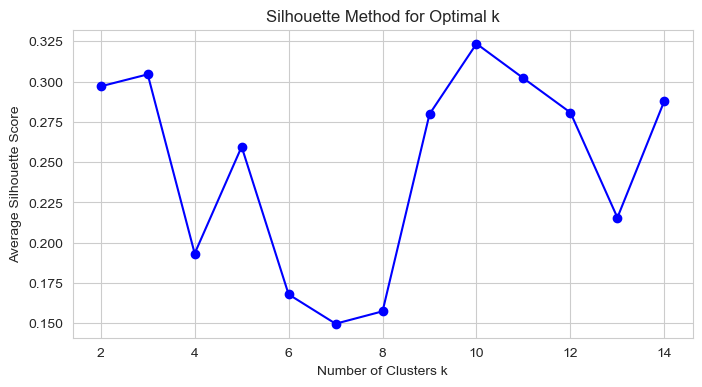

In [40]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

sil_scores = []
K_range = range(2, 15)  # 可自定义聚类数尝试范围

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
#     score = silhouette_score(X, kmeans.labels_)
#     sil_scores.append(score)

for k in K_range:
    try:
        clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        labels = clustering.fit_predict(X_final)
        score = silhouette_score(X_final, labels)
        sil_scores.append(score)
    except Exception as e:
        sil_scores.append(np.nan)
        print(f"k={k} 失败: {e}")
# 可视化平均轮廓系数
plt.figure(figsize=(8, 4))
plt.plot(K_range, sil_scores, 'bo-')
plt.xlabel("Number of Clusters k")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True)
plt.show()


### 对比不同的降维维度

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

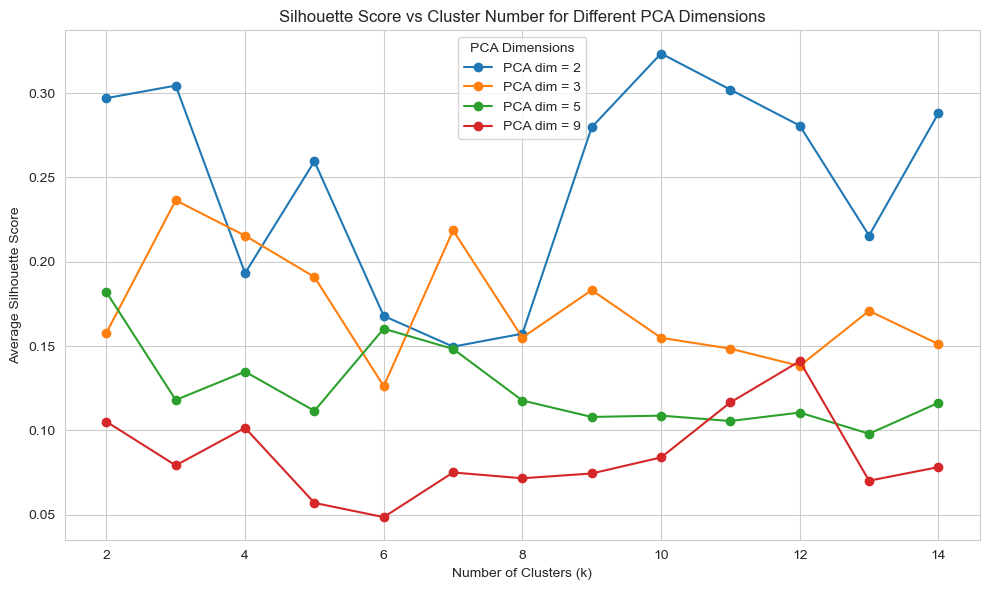

In [45]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 参数设置
pca_dims = [2, 3, 5, 9]
k_range = range(2, 15)

# 储存结果
results = {}

# 主循环
for dim in pca_dims:
    pca = PCA(n_components=dim)
    X_pca = pca.fit_transform(X_final)
    silhouette_scores = []

    for k in k_range:
        # kmeans = KMeans(n_clusters=k, random_state=42)
        clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
        # labels = kmeans.fit_predict(X_pca)
        labels = clustering.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    results[dim] = silhouette_scores

# 可视化
plt.figure(figsize=(10, 6))
for dim, scores in results.items():
    plt.plot(k_range, scores, marker='o', label=f'PCA dim = {dim}')

plt.title("Silhouette Score vs Cluster Number for Different PCA Dimensions")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.legend(title="PCA Dimensions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering



pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_final)

n_clusters = 3 # 你可以试着调成 3～6
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# labels = kmeans.fit_predict(X_pca)
clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(X)
# model = AgglomerativeClustering(n_clusters=3, linkage='ward')  # linkage 可以是 'ward', 'average',
# labels = model.fit_predict(X_pca)  # X_pca 是你降维后的特征向量
# X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_final)
# plt.figure(figsize=(8,6))
# plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='Set2')
# plt.title("CNN-based Patch Clustering")
# plt.show()

# Z = linkage(X_pca, method='ward')  # 使用同样的 linkage 方法
# plt.figure(figsize=(10, 6))
# dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12.)
# plt.title("Agglomerative Clustering Dendrogram")
# plt.xlabel("Cluster index")
# plt.ylabel("Distance")
# plt.show()

# # 画3D散点图
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
#                      c=labels, cmap='Set2', s=40)
#
# # 添加标签
# ax.set_title("3D PCA of CNN-based Patch Clustering")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
#
# # 可选：加图例
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)
#
# plt.tight_layout()
# plt.show()

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### 尝试选出合理的聚类算法

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\sklearn\cluster\_kmeans.py:14

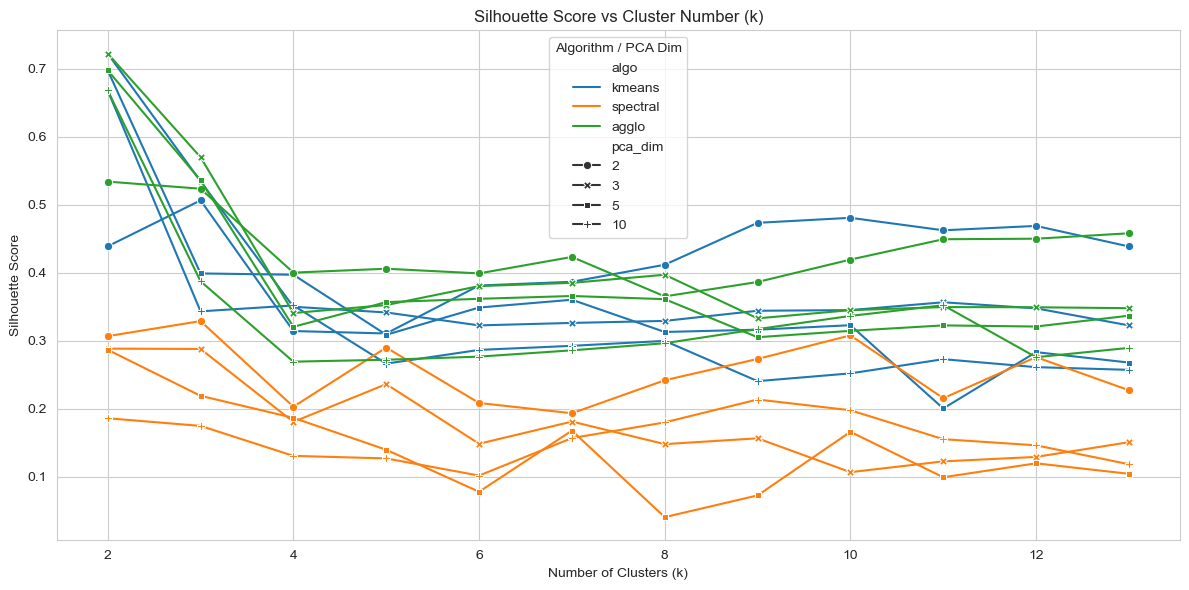

In [59]:

import seaborn as sns


algorithms = ['kmeans', 'spectral', 'agglo']
results = []

for algo in algorithms:
    for dim in [2, 3, 5, 10]:
        X_pca = PCA(n_components=dim).fit_transform(X_final)
        for k in range(2, 14):
            try:
                if algo == 'kmeans':
                    model = KMeans(n_clusters=k, random_state=42)
                elif algo == 'spectral':
                    model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
                elif algo == 'agglo':
                    model = AgglomerativeClustering(n_clusters=k, linkage='ward')

                labels = model.fit_predict(X_pca)
                score = silhouette_score(X_pca, labels)

                # 保存
                results.append({
                    'algo': algo,
                    'pca_dim': dim,
                    'k': k,
                    'score': score
                })

            except Exception as e:
                print(f"{algo}, PCA={dim}, k={k} failed: {e}")

df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='k', y='score', hue='algo', style='pca_dim', markers=True, dashes=False)
plt.title("Silhouette Score vs Cluster Number (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend(title="Algorithm / PCA Dim")
plt.grid(True)
plt.tight_layout()
plt.show()

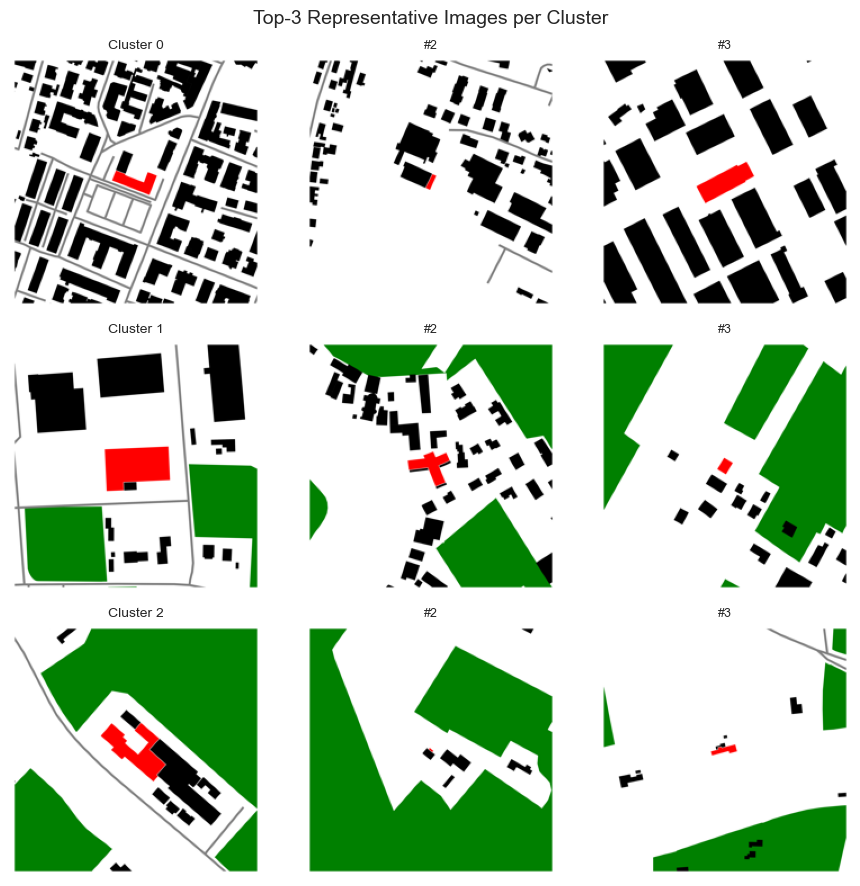

In [77]:
import matplotlib.pyplot as plt

topk = 3
representative_clusters = {}

for cluster_id in np.unique(labels):
    idx = np.where(labels == cluster_id)[0]
    cluster_points = X_pca[idx]
    # center = kmeans.cluster_centers_[cluster_id]
    center = np.mean(cluster_points, axis=0)
    distances = np.linalg.norm(cluster_points - center, axis=1)

    sorted_indices = idx[np.argsort(distances)[:topk]]
    representative_clusters[cluster_id] = sorted_indices

topk = 3  # 你已经设定为 3
n_clusters = len(representative_clusters)

plt.figure(figsize=(topk * 3, n_clusters * 3))

for cluster_id, indices in representative_clusters.items():
    for rank, idx in enumerate(indices):
        plt_idx = cluster_id * topk + rank + 1  # subplot index
        plt.subplot(n_clusters, topk, plt_idx)
        img = img_list[idx]

        # 若图像归一化（0~1），需要乘回 255
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.axis("off")
        if rank == 0:
            plt.title(f"Cluster {cluster_id}", fontsize=10)
        else:
            plt.title(f"#{rank+1}", fontsize=9)

plt.suptitle("Top-3 Representative Images per Cluster", fontsize=14)
plt.tight_layout()
plt.show()


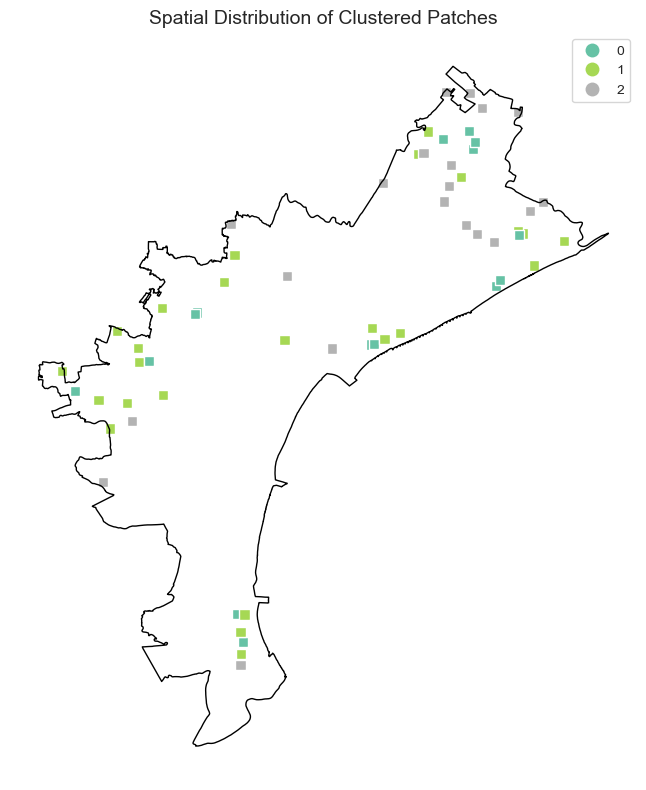

In [79]:
patches_with_gwr = patches_with_gwr.copy()
patches_with_gwr['cluster'] = labels  # 新增一列
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
patches_with_gwr.plot(column='cluster', cmap='Set2', categorical=True, legend=True, ax=ax)

ax.set_title("Spatial Distribution of Clustered Patches", fontsize=14)
ax.axis("off")
plt.tight_layout()
gdf_boundary=gpd.read_file("origin_data/00_Boundaries").to_crs(epsg=32632)
gdf_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
plt.show()
